# Experiment 7

This experiment aims to use the absolute numbers of links explored in the simulation as a metric rather than the percentage explored as this will enable better comparison between different networks.

In [76]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import networkx as nx

import logging

from src.simulation import Simulation
from src.network import Network
from src.render import Render

logging.disable(logging.CRITICAL)

In [2]:
network_file_1 = "networks/Net3.inp"
network_file_2 = "networks/250701 K709vs2-Export.inp"
network_file_3 = "networks/Net6.inp"

env1 = Network(network_file_1)
env2 = Network(network_file_2)
env3 = Network(network_file_3)

g_env1 = env1.water_network_model.to_graph().to_undirected()
g_env2 = env2.water_network_model.to_graph().to_undirected()
g_env3 = env3.water_network_model.to_graph().to_undirected()

d_env1 = g_env1.degree
d_env2 = g_env2.degree
d_env3 = g_env3.degree

env1_start_pool = [node for node, degree in d_env1 if degree == 1]
env2_start_pool = [node for node, degree in d_env2 if degree == 1]
env3_start_pool = [node for node, degree in d_env3 if degree == 1]

env1_num_links = env1.graph_num_links
env2_num_links = env2.graph_num_links
env3_num_links = env3.graph_num_links

print("Start Pool - Net3: ", env1_start_pool)
print("Number of Start Nodes - Net3: ", len(env1_start_pool))
print("Number of Nodes - Net3: ", env1.graph_num_nodes)
print("Number of Links - Net3: ", env1.graph_num_links)

print("Start Pool - 250701 K709vs2-Export: ", env2_start_pool)
print("Number of Start Nodes - 250701 K709vs2-Export: ", len(env2_start_pool))
print("Number of Nodes - 250701 K709vs2-Export: ", env2.graph_num_nodes)
print("Number of Links - 250701 K709vs2-Export: ", env2.graph_num_links)

print("Start Pool - Net6: ", env3_start_pool)
print("Number of Start Nodes - Net6: ", len(env3_start_pool))
print("Number of Nodes - Net6: ", env3.graph_num_nodes)
print("Number of Links - Net6: ", env3.graph_num_links)

Start Pool - Net3:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2', '3']
Number of Start Nodes - Net3:  16
Number of Nodes - Net3:  97
Number of Links - Net3:  119
Start Pool - 250701 K709vs2-Export:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187', 'A5189', 'A5191', 'A5197', 'A5200', 'A5202', 'A5205', 'A5245', 'A5247', 'A5255', 'A5271', 'A5279', 'A5283', 'A5285', 'A5306', 'A5311', 'A5323', 'A5342', 'A5343', 'A5348', 'A5351', 'A5354', 'A5357', 'A5376', 'A5377', 'A5379', 'A5383', 'A5387', 'A5390', 'A5391', 'A5394', 'A5396', 'A5398', 'A5400', 'A5404', 'A5407', 'A5408', 'A5412', 'A5423', 'A5424', 'A5426', 'A5428', 'A5430', 'A5431', 'A5435', 'A5440', 'A5448', 'A5450', 'A5451', 'A5460', 'A5462', 'A5471', 'A5473', 'A5474', 'A5480', 'A5481', 'A5485', 'A5502', 'A5510', 'A5513', 'A5515', 'A5701', 'A5708', 'AN-1871', 'N-0457', 'N-0458', 'N-0459', 'N-0460',

In [3]:
def run_simulation_batch(env, num_agents, start_nodes, filepath, max_turns=100):
    print("Starting Simulation Batch - ", filepath)
    print("Number of Agents: ", num_agents)
    print("Start Nodes: ", start_nodes)
    print("Max Turns: ", max_turns)
    
    # Run the simulations for no swarm control
    path = f'{filepath}/NoSwarm'
    simulations_1 = []
    for node in start_nodes:
        print("Starting No Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=False, start_positions=[node], filepath=path)
        simulations_1.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_1
    
    # Run the simulations for naive swarm control
    path = f'{filepath}/NaiveSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'naive'}
    simulations_2 = []
    for node in start_nodes:
        print("Starting Naive Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_2.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_2
    
    # Run the simulations for informed mean swarm control
    path = f'{filepath}/InformedMeanSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'mean'}
    simulations_3 = []
    for node in start_nodes:
        print("Starting Informed Mean Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_3.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)    
    yield simulations_3
    
    # Run the simulations for informed median swarm control
    path = f'{filepath}/InformedMedianSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'median'}
    simulations_4 = []
    for node in start_nodes:
        print("Starting Informed Median Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_4.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_4

## Simulation 7.1

This set of simulations will focus on `env1`. There will be 10 agents, and the number of turns will be 100. In each simulation, all agents will begin at the same start node though to reduce the influence of the starting position on the final resuslts, the simulation will be run 15 times with the first 15 nodes in the starting node pool as the agent starting positions. The number of unique links explored will be recorded for each simulation.

In [4]:
start_nodes = env1_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-7/Env1"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']


In [5]:
simulations_7_1 = run_simulation_batch(env1, num_agents, start_nodes, filepath, max_turns=max_turns)

no_swarm_env1 = next(simulations_7_1)
naive_swarm_env1 = next(simulations_7_1)
informed_mean_swarm_env1 = next(simulations_7_1)
informed_median_swarm_env1 = next(simulations_7_1)

Starting Simulation Batch -  notable-results/Experiment-7/Env1
Number of Agents:  10
Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  15
Starting No Swarm Simulation from Start Node:  35
Starting No Swarm Simulation from Start Node:  131
Starting No Swarm Simulation from Start Node:  166
Starting No Swarm Simulation from Start Node:  167
Starting No Swarm Simulation from Start Node:  203
Starting No Swarm Simulation from Start Node:  219
Starting No Swarm Simulation from Start Node:  225
Starting No Swarm Simulation from Start Node:  231
Starting No Swarm Simulation from Start Node:  243
Starting No Swarm Simulation from Start Node:  253
Starting No Swarm Simulation from Start Node:  River
Starting No Swarm Simulation from Start Node:  Lake
Starting No Swarm Simulation from Start Node:  1
Starting No Swarm Simulation from Start Node:  2
Starting Naive Swarm

## Simulation 7.2

This set of simulations will focus on `env2`. There will be 10 agents, and the number of turns will be 100. In each simulation, all agents will begin at the same start node though to reduce the influence of the starting position on the final resuslts, the simulation will be run 15 times with the first 15 nodes in the starting node pool as the agent starting positions. The number of unique links explored will be recorded for each simulation.

In [ ]:
start_nodes = env2_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-7/Env2"

print("Start Nodes: ", start_nodes)

In [ ]:
simulations_7_2 = run_simulation_batch(env2, num_agents, start_nodes, filepath, max_turns=max_turns)
no_swarm_env2 = next(simulations_7_2)
naive_swarm_env2 = next(simulations_7_2)
informed_mean_swarm_env2 = next(simulations_7_2)
informed_median_swarm_env2 = next(simulations_7_2)

## Simulation 7.3

This set of simulations will focus on `env3`. There will be 10 agents, and the number of turns will be 100. In each simulation, all agents will begin at the same start node though to reduce the influence of the starting position on the final resuslts, the simulation will be run 15 times with the first 15 nodes in the starting node pool as the agent starting positions. The number of unique links explored will be recorded for each simulation.

In [ ]:
start_nodes = env3_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-7/Env3"

print("Start Nodes: ", start_nodes)

In [ ]:
simulations_7_3 = run_simulation_batch(env3, num_agents, start_nodes, filepath, max_turns=max_turns)
no_swarm_env3 = next(simulations_7_3)
naive_swarm_env3 = next(simulations_7_3)
informed_mean_swarm_env3 = next(simulations_7_3)
informed_median_swarm_env3 = next(simulations_7_3)

# Analysis

### Dataframe/Results functions

In [6]:
# Read the results from the simulations
def read_results(simulations):
    results = []
    for sim in simulations:
        start_node, path = sim
        df = pd.read_csv(f"{path}/results.csv")
        df['start_node'] = start_node
        df.start_node = start_node
        results.append(df)
    return results
            
# Make the results into a single dataframe with turns as the columns and the data of interest as the rows
def make_results_dataframe(results, data_of_interest):
    df = pd.DataFrame()
    # Get the data of interest
    data = [result[['turn', data_of_interest, 'start_node']] for result in results]
    
    # Make the turn number the columns
    for result in data:
        start_node = result.start_node.unique()[0]

        result = result.T
        result.columns = result.iloc[0].astype(int)
        result = result.drop('turn')
        
        # Drop the start node row
        result = result.drop('start_node')
        # Add the start node to the dataframe
        result['start_node'] = start_node
        
        if df.empty:
            df = result
        else:
            df = pd.concat([df, result])
            
    # Check that each column that is a turn number has data of numeric type and if not, make it numeric (float)
    for column in df.columns:
        if column != 'start_node':
            if not pd.api.types.is_numeric_dtype(df[column]):
                df[column] = pd.to_numeric(df[column], errors='coerce')
            
    # Get the mean, min, max and standard deviation for each column
    df.loc['mean'] = df.mean(numeric_only=True)
    df.loc['min'] = df.min(numeric_only=True)
    df.loc['max'] = df.max(numeric_only=True)
    df.loc['std'] = df.std(numeric_only=True)
            
    return df

# Get the results from the simulations and make them into a dataframe
def get_results(simulations, data_of_interest):
    results = read_results(simulations)
    df = make_results_dataframe(results, data_of_interest)
    return df

# Get a list of dataframes with the results from the simulations for each environment
def l_environment_dataframe(swarm_types:list, simulations:list):
    experiment_dfs = []
    for simulation in simulations:
        df = read_results(simulation)
        experiment_dfs.append(df)
        
    return experiment_dfs

# Get a dataframe with the results from the simulations for each environment
def environment_dataframe(swarm_types:list, simulations:list, data_of_interest):
    experiment_dfs = []
    for simulation in simulations:
        df = get_results(simulation, data_of_interest)
        experiment_dfs.append(df)
    
    dataframe = pd.DataFrame()
    
    for swarm_type, df in zip(swarm_types, experiment_dfs):
        dataframe[f'{swarm_type}-mean'] = df.loc['mean']
        dataframe[f'{swarm_type}-min'] = df.loc['min']
        dataframe[f'{swarm_type}-max'] = df.loc['max']
        dataframe[f'{swarm_type}-std'] = df.loc['std']
        
    # Drop any columns that are all NaN
    dataframe = dataframe.dropna(axis=1, how='all')
    # Drop any rows that are all NaN
    dataframe = dataframe.dropna(axis=0, how='all')
    
    return dataframe

def start_node_results(swarm_types, sims):
    results = pd.DataFrame()
    
    for swarm_type, sim in zip(swarm_types, sims):
        for start_node, simulation_path in sim:
            path = f'{simulation_path}/results.csv'
            df = pd.read_csv(path)
            df.start_node = start_node
            # Get the mean pct_links_explored for the entire simulation run
            mean_pct_links_explored = df.pct_links_explored.mean()
            # Get the mean link_novelty_score for the entire simulation run
            mean_link_novelty_score = df.link_novelty_score.mean()
            # Add the mean values to the results dataframe for the given swarm type and start node
            temp = pd.DataFrame({'swarm_type': swarm_type, 'start_node': start_node, 'mean_pct_links_explored': mean_pct_links_explored, 'mean_link_novelty_score': mean_link_novelty_score}, index=[0])
            results = pd.concat([results, temp], ignore_index=True)
            
    return results

### Plotting Functions

In [7]:
# Function to plot the error bars according to the min and max values
def plot_errorbar_min_max(df, swarm_type, ax, color, label, errorevery):
    ax.errorbar(
        df.index,
        df[f'{swarm_type}-mean'],
        yerr=[df[f'{swarm_type}-mean'] - df[f'{swarm_type}-min'], df[f'{swarm_type}-max'] - df[f'{swarm_type}-mean']],
        errorevery=errorevery,
        label=label,
        color=color,
        capsize=5)

# Function to plot the error bars according to the standard deviation
def plot_errorbar_std(df, swarm_type, ax, color, label, errorevery):
    ax.errorbar(
        df.index,
        df[f'{swarm_type}-mean'],
        yerr=df[f'{swarm_type}-std'],
        errorevery=errorevery,
        color=color,
        capsize=5
    )
    
# Function to fill in the area between the error bars
def fill_area_between_min_and_max(dataframe, swarm_type, ax, colour='lightblue', alpha=0.3):
    x = dataframe.index.astype(int)
    y1 = dataframe[f'{swarm_type}-min'].astype(float)
    y2 = dataframe[f'{swarm_type}-max'].astype(float)
        
    ax.fill_between(x, y1, y2, color=colour, alpha=alpha)
 
swarm_type_to_linestyle = {
    'no-swarm': 'solid',
    'naive': 'dashed',
    'informed-mean': 'dotted',
    'informed-median': 'dashdot'
}
    
swarm_type_to_colour = {
    'no-swarm': 'black',
    'naive': 'red',
    'informed-mean': 'blue',
    'informed-median': 'green'
}

swarm_type_to_errorbar = {
    'no-swarm': (0,10),
    'naive': (3,10),
    'informed-mean': (6,10),
    'informed-median': (8,10)
}

# Plot the percentage of links explored by the swarm as a function of turns
def plot_pct_explored_results(results, swarm_types, title, ylabel, xlabel='Turns', figsize=(10,10)):
    # Set the figure size
    plt.figure(figsize=figsize)
    
    # Plot the mean and standard deviation for each swarm type
    for swarm_type in swarm_types:
        linestyle = swarm_type_to_linestyle[swarm_type]
        colour = swarm_type_to_colour[swarm_type]
        errorevery = swarm_type_to_errorbar[swarm_type]

        plt.plot(results[f'{swarm_type}-mean'], label=f'{swarm_type}-mean', color=colour, linestyle=linestyle)
            
        # fill_area_between_min_and_max(df, swarm_type, plt, colour=colour, alpha=0.15)
        
        plot_errorbar_std(results, swarm_type, plt, colour, f'{swarm_type}-std', errorevery)
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

# Plot the absolute numbers of links explored by the swarm as a function of turns
def plot_abs_explored_results(results, swarm_types, title, ylabel, xlabel='Turns', figsize=(10,10)):
    # Set the figure size
    plt.figure(figsize=figsize)
    
    # Plot the mean and standard deviation for each swarm type
    for swarm_type in swarm_types:
        linestyle = swarm_type_to_linestyle[swarm_type]
        colour = swarm_type_to_colour[swarm_type]
        errorevery = swarm_type_to_errorbar[swarm_type]

        plt.plot(results[f'{swarm_type}-mean'], label=f'{swarm_type}-mean', color=colour, linestyle=linestyle)
            
        # fill_area_between_min_and_max(df, swarm_type, plt, colour=colour, alpha=0.15)
        
        plot_errorbar_std(results, swarm_type, plt, colour, f'{swarm_type}-std', errorevery)
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

# Plot the link novelty as a function of turns
def plot_link_novelty(results, swarm_types, title, ylabel, xlabel='Turns', figsize=(10,10)):
    # Set the figure size
    plt.figure(figsize=figsize)
    
    # Plot the mean and standard deviation for each swarm type
    for swarm_type in swarm_types:
        linestyle = swarm_type_to_linestyle[swarm_type]
        colour = swarm_type_to_colour[swarm_type]
        errorevery = swarm_type_to_errorbar[swarm_type]

        plt.plot(results[f'{swarm_type}-mean'], label=f'{swarm_type}-mean', color=colour, linestyle=linestyle)
            
        # fill_area_between_min_and_max(df, swarm_type, plt, colour=colour, alpha=0.15)
        
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

### Misc Functions/Variables

In [43]:
swarm_types = ['no-swarm', 'naive', 'informed-mean', 'informed-median']

## Analysis 7.1.1

This analysis will focus on the results of the simulations in simulation 7.1. The results will be analysed to determine the effect of the swarm control strategy on the absolute number of links explored at each turn and then the total number of links explored in the turn limit.

### Results

In [9]:
sims = [no_swarm_env1, naive_swarm_env1, informed_mean_swarm_env1, informed_median_swarm_env1]
results_7_1_1 = environment_dataframe(swarm_types, sims, 'abs_links_explored')
results_7_1_1

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,2.0,2.0,2.0,0.0,2.8,2.0,4.0,0.705904,2.8,2.0,4.0,0.705904,2.8,2.0,4.0,0.705904
2,2.933333,2.0,3.0,0.322414,5.533333,4.0,8.0,1.574064,5.133333,4.0,8.0,1.394709,5.133333,4.0,8.0,1.394709
3,3.866667,3.0,4.0,0.381356,7.8,5.0,12.0,2.398175,7.8,5.0,13.0,2.388206,7.8,5.0,13.0,2.388206
4,4.8,3.0,5.0,0.665882,9.8,6.0,15.0,2.987928,10.6,6.0,18.0,3.281718,10.6,6.0,18.0,3.281718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,43.266667,16.0,62.0,16.576555,84.533333,38.0,119.0,30.90683,98.533333,82.0,118.0,9.547274,98.533333,82.0,118.0,9.547274
96,43.266667,16.0,62.0,16.576555,84.533333,38.0,119.0,30.90683,98.733333,82.0,118.0,9.615507,98.733333,82.0,118.0,9.615507
97,43.266667,16.0,62.0,16.576555,84.533333,38.0,119.0,30.90683,98.933333,82.0,118.0,9.722491,98.933333,82.0,118.0,9.722491


### Graphs

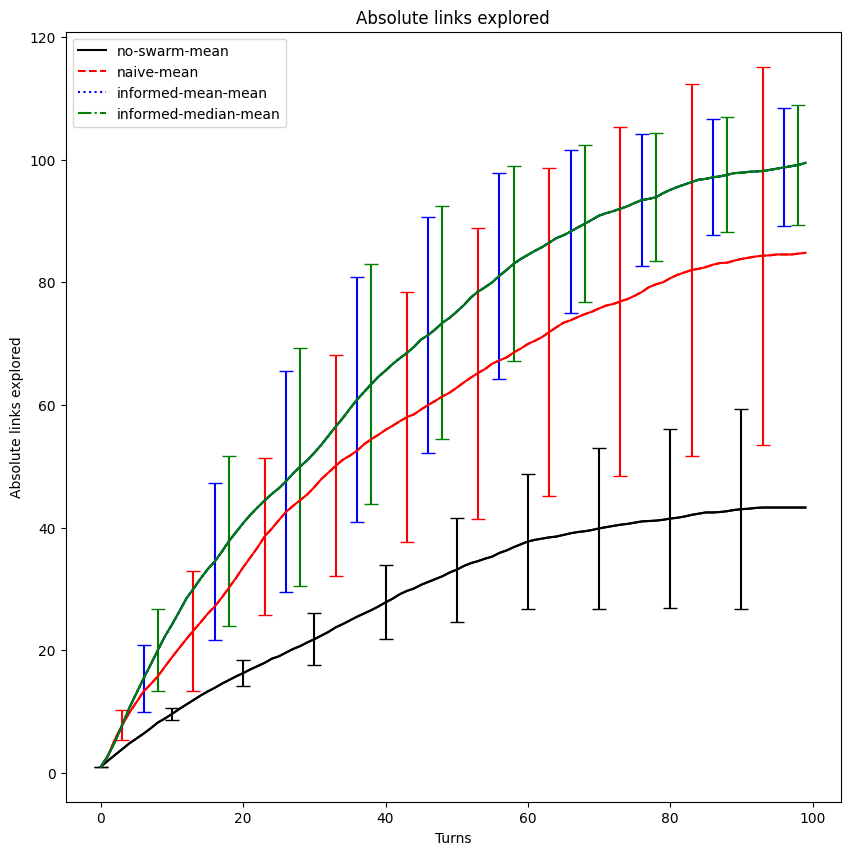

In [10]:
# Plot the results
plot_abs_explored_results(results_7_1_1, swarm_types, 'Absolute links explored', 'Absolute links explored')

## Analysis 7.1.2

This analysis will focus on the results of the simulations in simulation 7.2. The results will be analysed to determine the effect of the swarm control strategy on the absolute number of links explored at each turn and then the total number of links explored in the turn limit.

### Results

In [ ]:
sims = [no_swarm_env2, naive_swarm_env2, informed_mean_swarm_env2, informed_median_swarm_env2]
results_7_1_2 = environment_dataframe(swarm_types, sims, 'abs_links_explored')
results_7_1_2

### Graphs

In [ ]:
# Plot the results
plot_abs_explored_results(results_7_1_2, swarm_types, 'Absolute links explored', 'Absolute links explored')

## Analysis 7.1.3

This analysis will focus on the results of the simulations in simulation 7.3. The results will be analysed to determine the effect of the swarm control strategy on the absolute number of links explored at each turn and then the total number of links explored in the turn limit.

### Results

In [ ]:
sims = [no_swarm_env3, naive_swarm_env3, informed_mean_swarm_env3, informed_median_swarm_env3]
results_7_1_3 = environment_dataframe(swarm_types, sims, 'abs_links_explored')
results_7_1_3

### Graphs

In [ ]:
# Plot the results
plot_abs_explored_results(results_7_1_3, swarm_types, 'Absolute links explored', 'Absolute links explored')

## Path Heatmap

In [28]:
def get_paths(simulations):
    """
    Get the paths of the agents in the simulations.
    In the resulting dataframe, each row is a simulation, and each column is an agent.
    """
    raw_paths = []
    for sim in simulations:
        start_node, path = sim
        paths = pd.read_csv(f'{path}/agent_results.csv')
        paths = paths['path']
        raw_paths.append(paths)
    
    sanitised_paths = []   
    for sim in raw_paths:
        sanitised_paths.append([])
        for path in sim:
            path = path[1:-1].replace('\'', '').split(', ')
            path = [node for node in path]
            sanitised_paths[-1].append(path)
            
    paths = pd.DataFrame(sanitised_paths)
    
    return paths

def get_edge_colour_map(paths:pd.DataFrame, graph:nx.Graph):
    # Each row is a simualtion, each column is an agent
    traversed_edges_dict = {}
    for index in paths.index:
        traversed_edges_dict[index] = set()
        for path in paths.loc[index]:
            for i in range(len(path) - 1):
                traversed_edges_dict[index].add((path[i], path[i+1]))
                
    edge_colours_dict = {}
    for sim in traversed_edges_dict:
        edge_colours_dict[sim] = ['green' if edge in traversed_edges_dict[sim] else 'red' for edge in graph.edges]
    
    return edge_colours_dict

def plot_sim_batch(sim_batch:list, env:Network, title:str):
    paths = get_paths(sim_batch)
    graph = env.graph
    pos = nx.get_node_attributes(graph, 'pos')
    edge_colours_dict = get_edge_colour_map(paths, graph)
    
    # Plot the graphs
    fig, axes = plt.subplots(5, 3, figsize=(20, 20))
    for i in range(5):
        for j in range(3):
            sim = i * 3 + j
            nx.draw_networkx(graph, pos, ax=axes[i][j], node_color='black', node_size=0, edge_color=edge_colours_dict[sim], width=0.75, with_labels=False)
            axes[i][j].scatter(pos[paths.loc[sim][0][0]][0], pos[paths.loc[sim][0][0]][1], color='blue', s=2)
            axes[i][j].set_title(f'Simulation {sim}')
            
            # Remove the axis labels
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
            
            # Remove the axis spines
            axes[i][j].spines['top'].set_visible(False)
            axes[i][j].spines['right'].set_visible(False)
            axes[i][j].spines['bottom'].set_visible(False)
            axes[i][j].spines['left'].set_visible(False)
            
    fig.suptitle(title, fontsize=16)
    fig.text(0.5, 0.04, 'Red edges are unexplored and Green edges are explored. The Blue node is the start node.', ha='center')
    plt.show()
                               
        

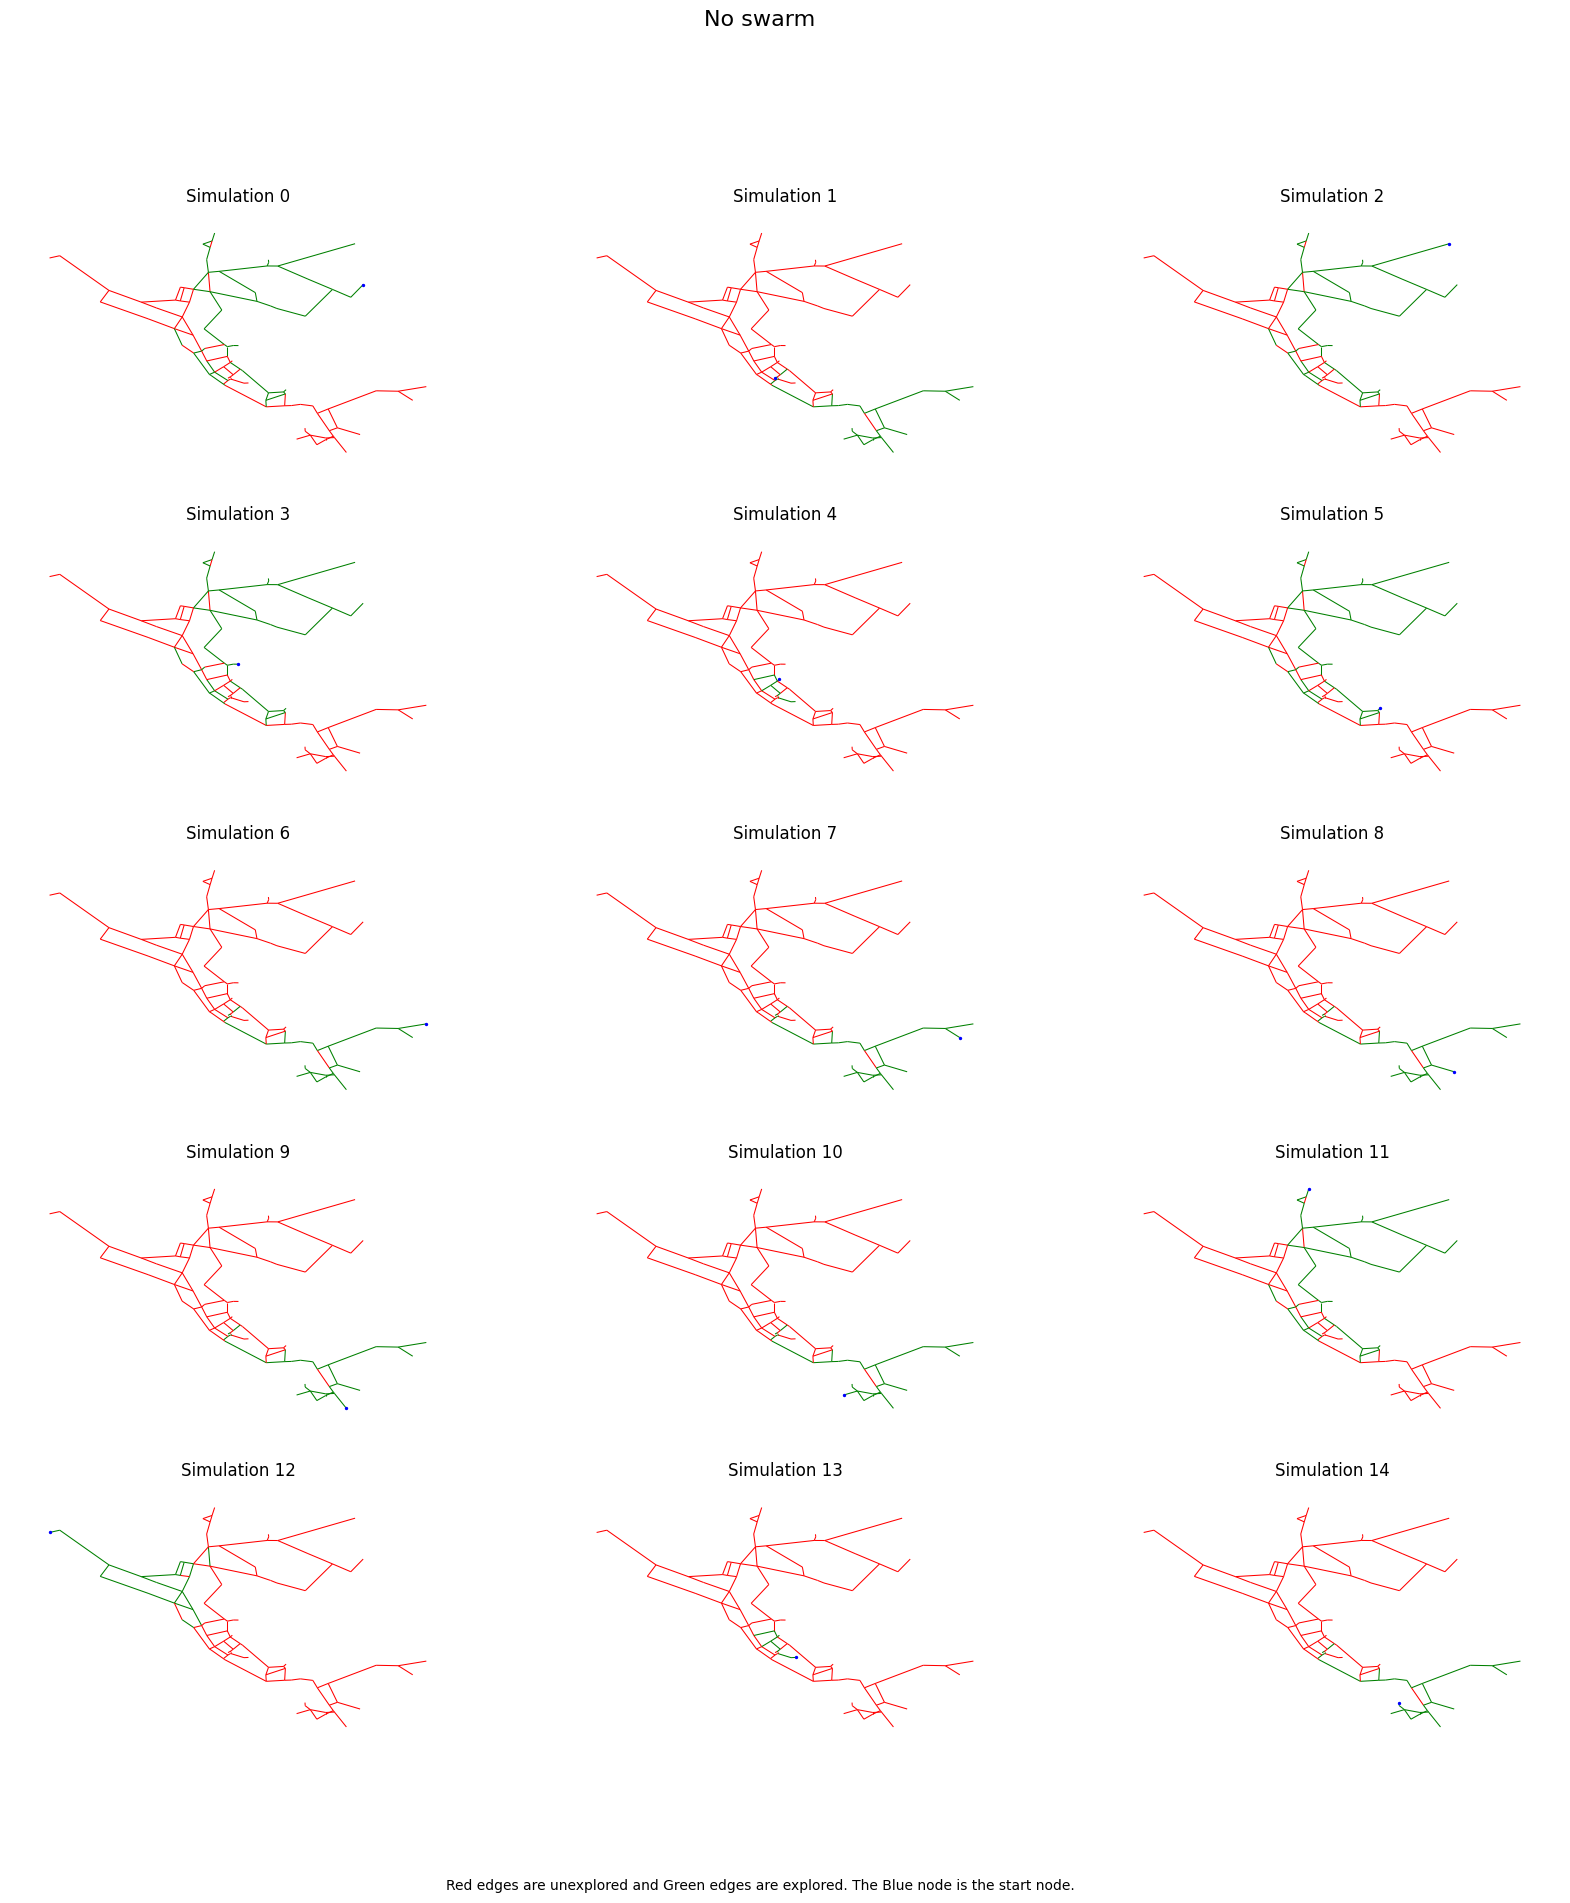

In [29]:
plot_sim_batch(no_swarm_env1, env1, 'No swarm')

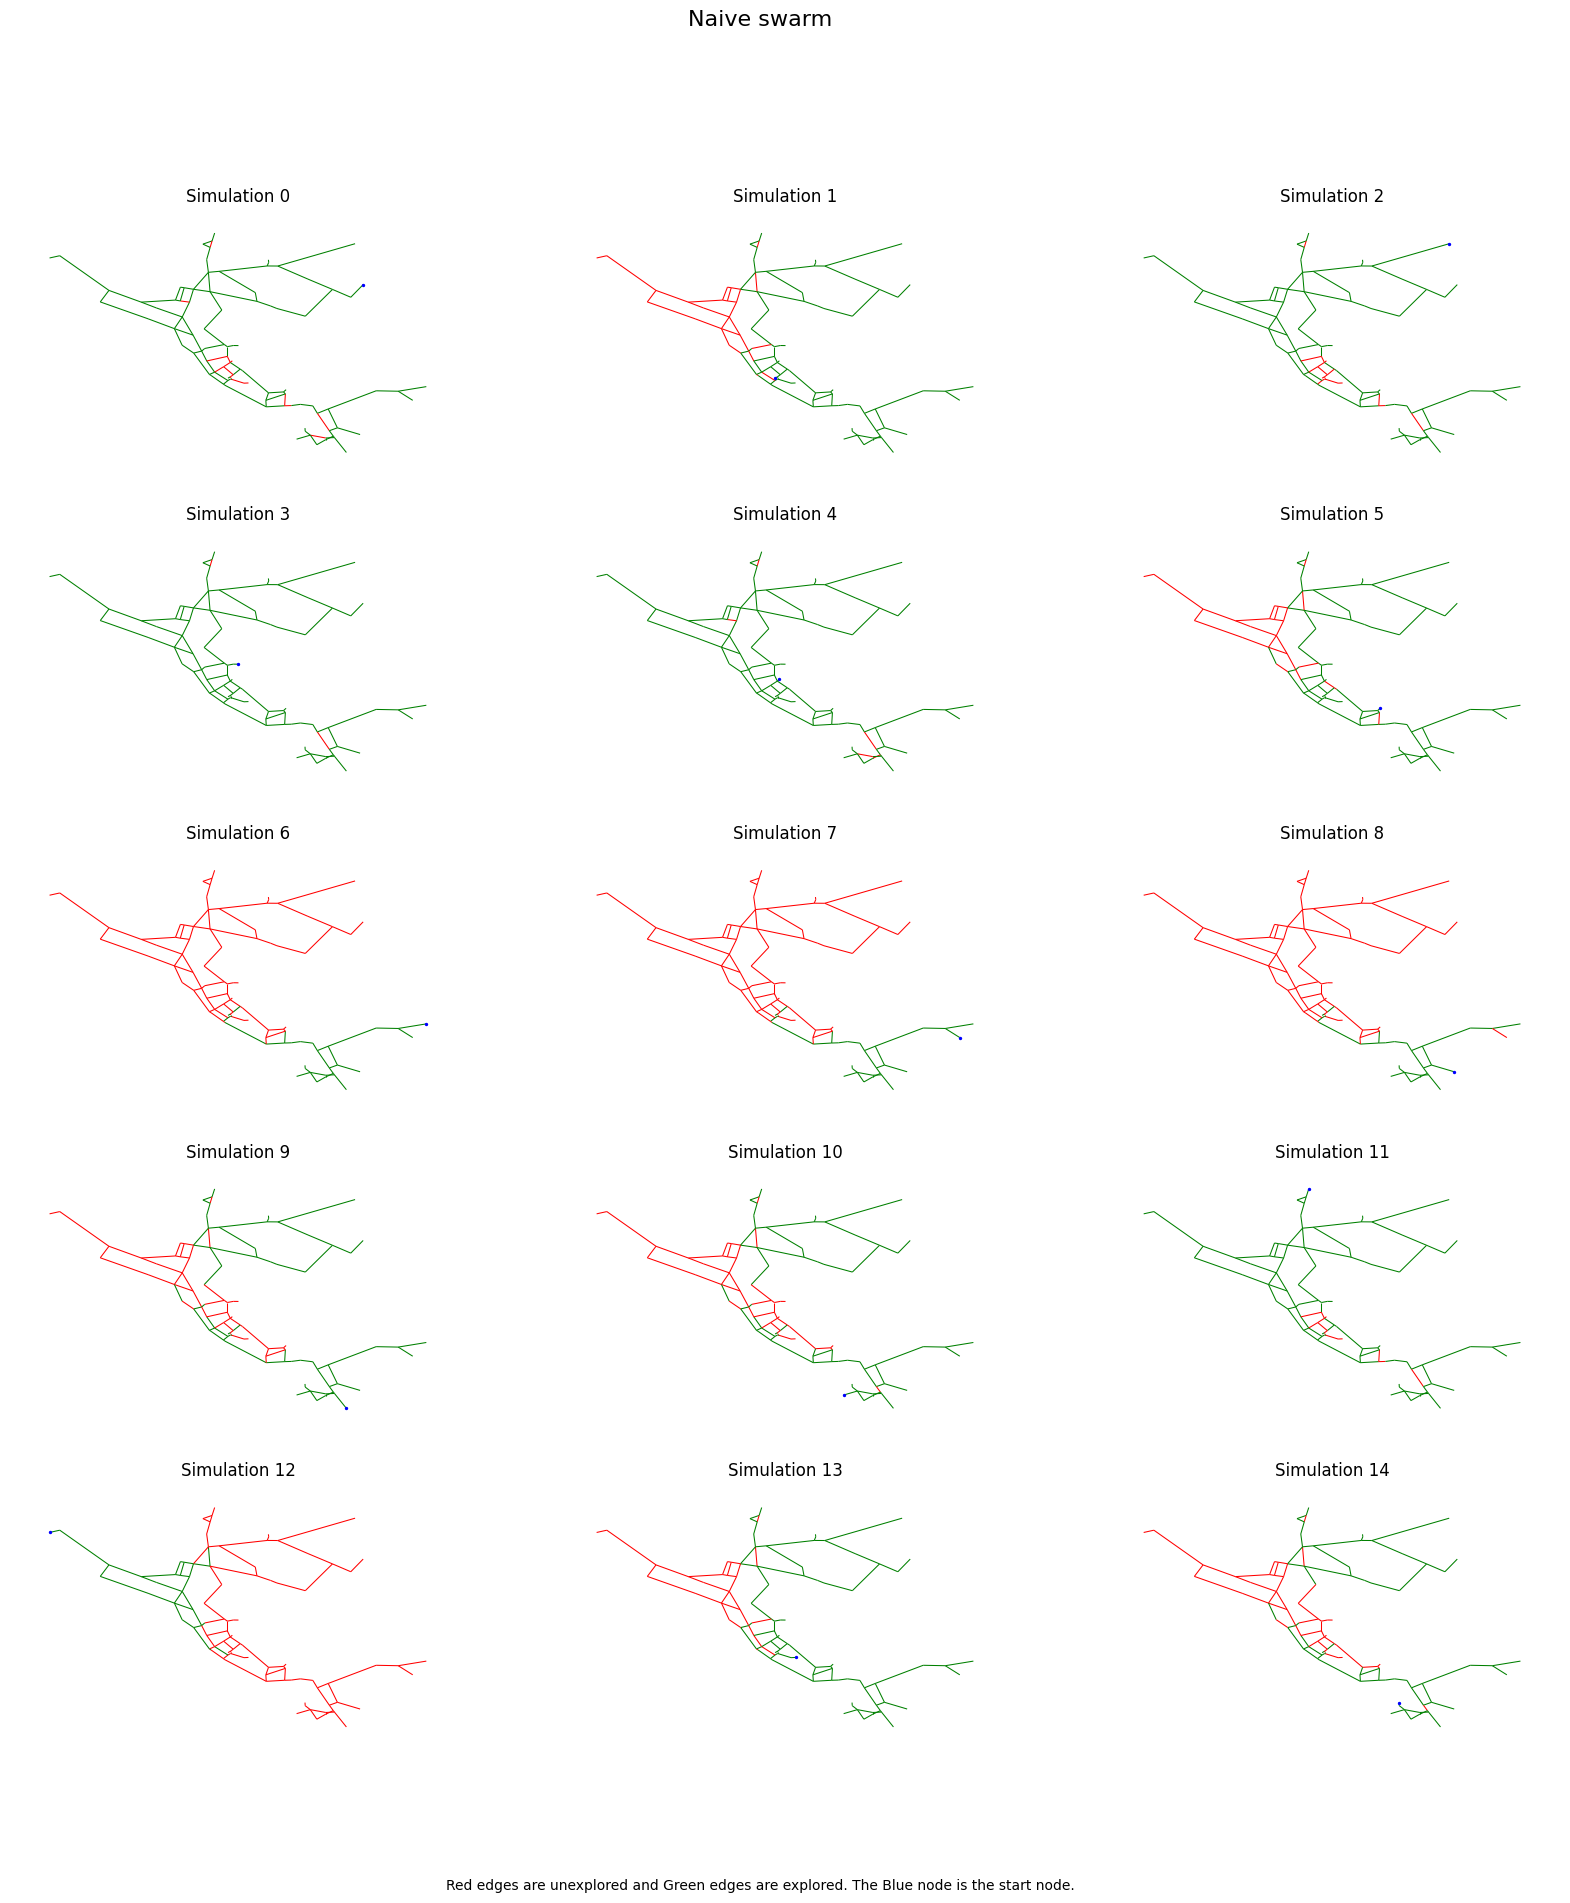

In [31]:
plot_sim_batch(naive_swarm_env1, env1, 'Naive swarm')

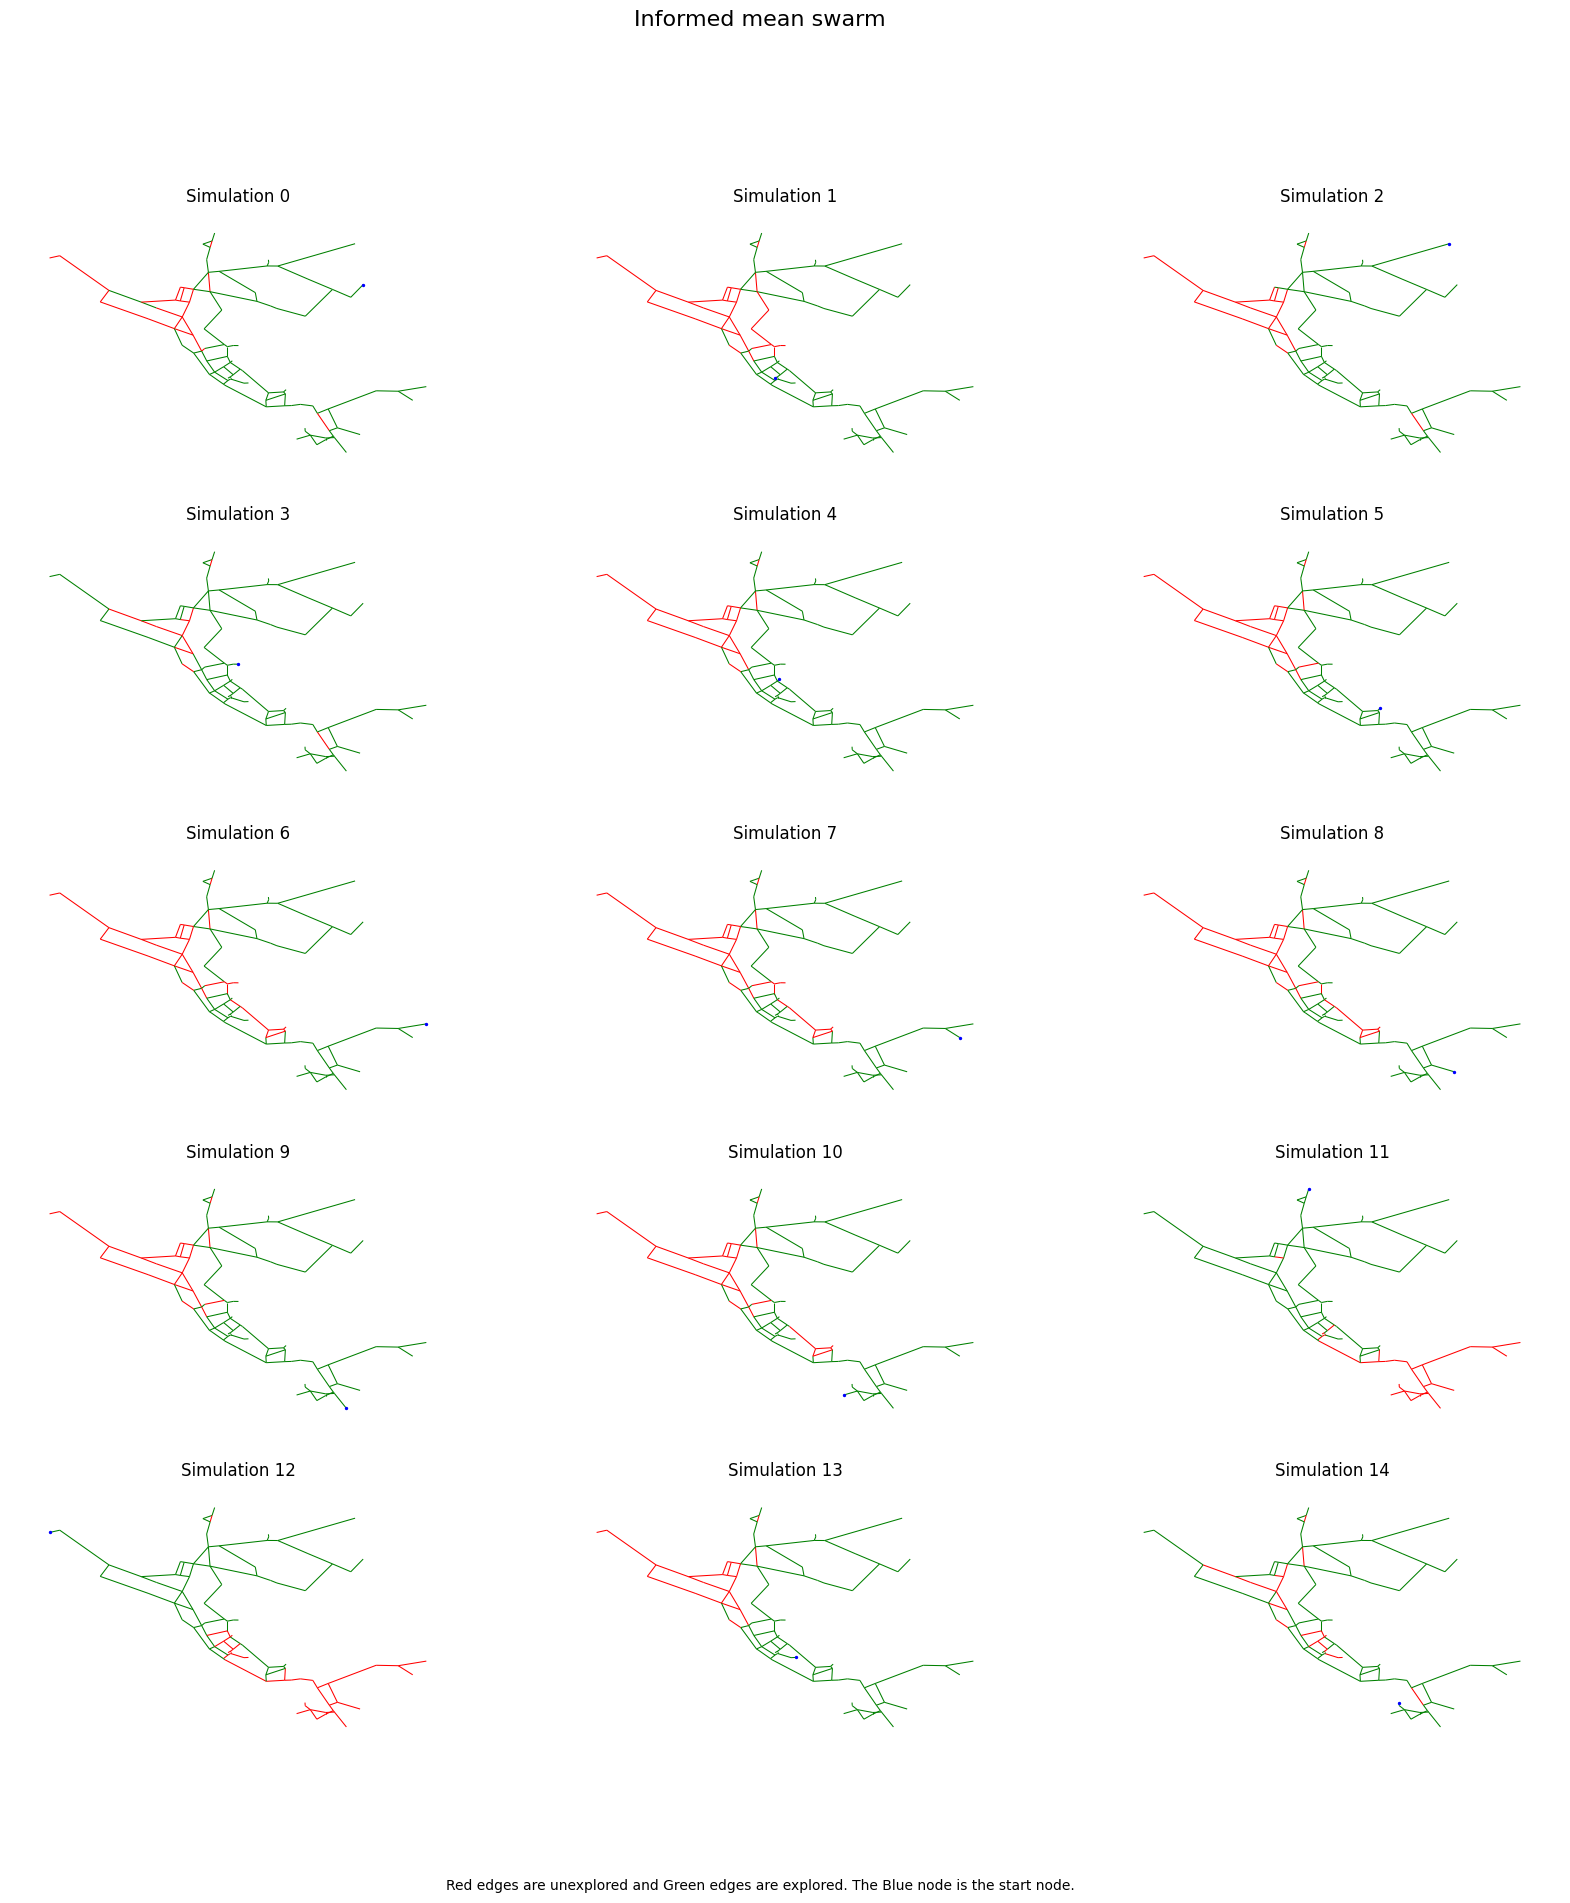

In [30]:
plot_sim_batch(informed_mean_swarm_env1, env1, 'Informed mean swarm')

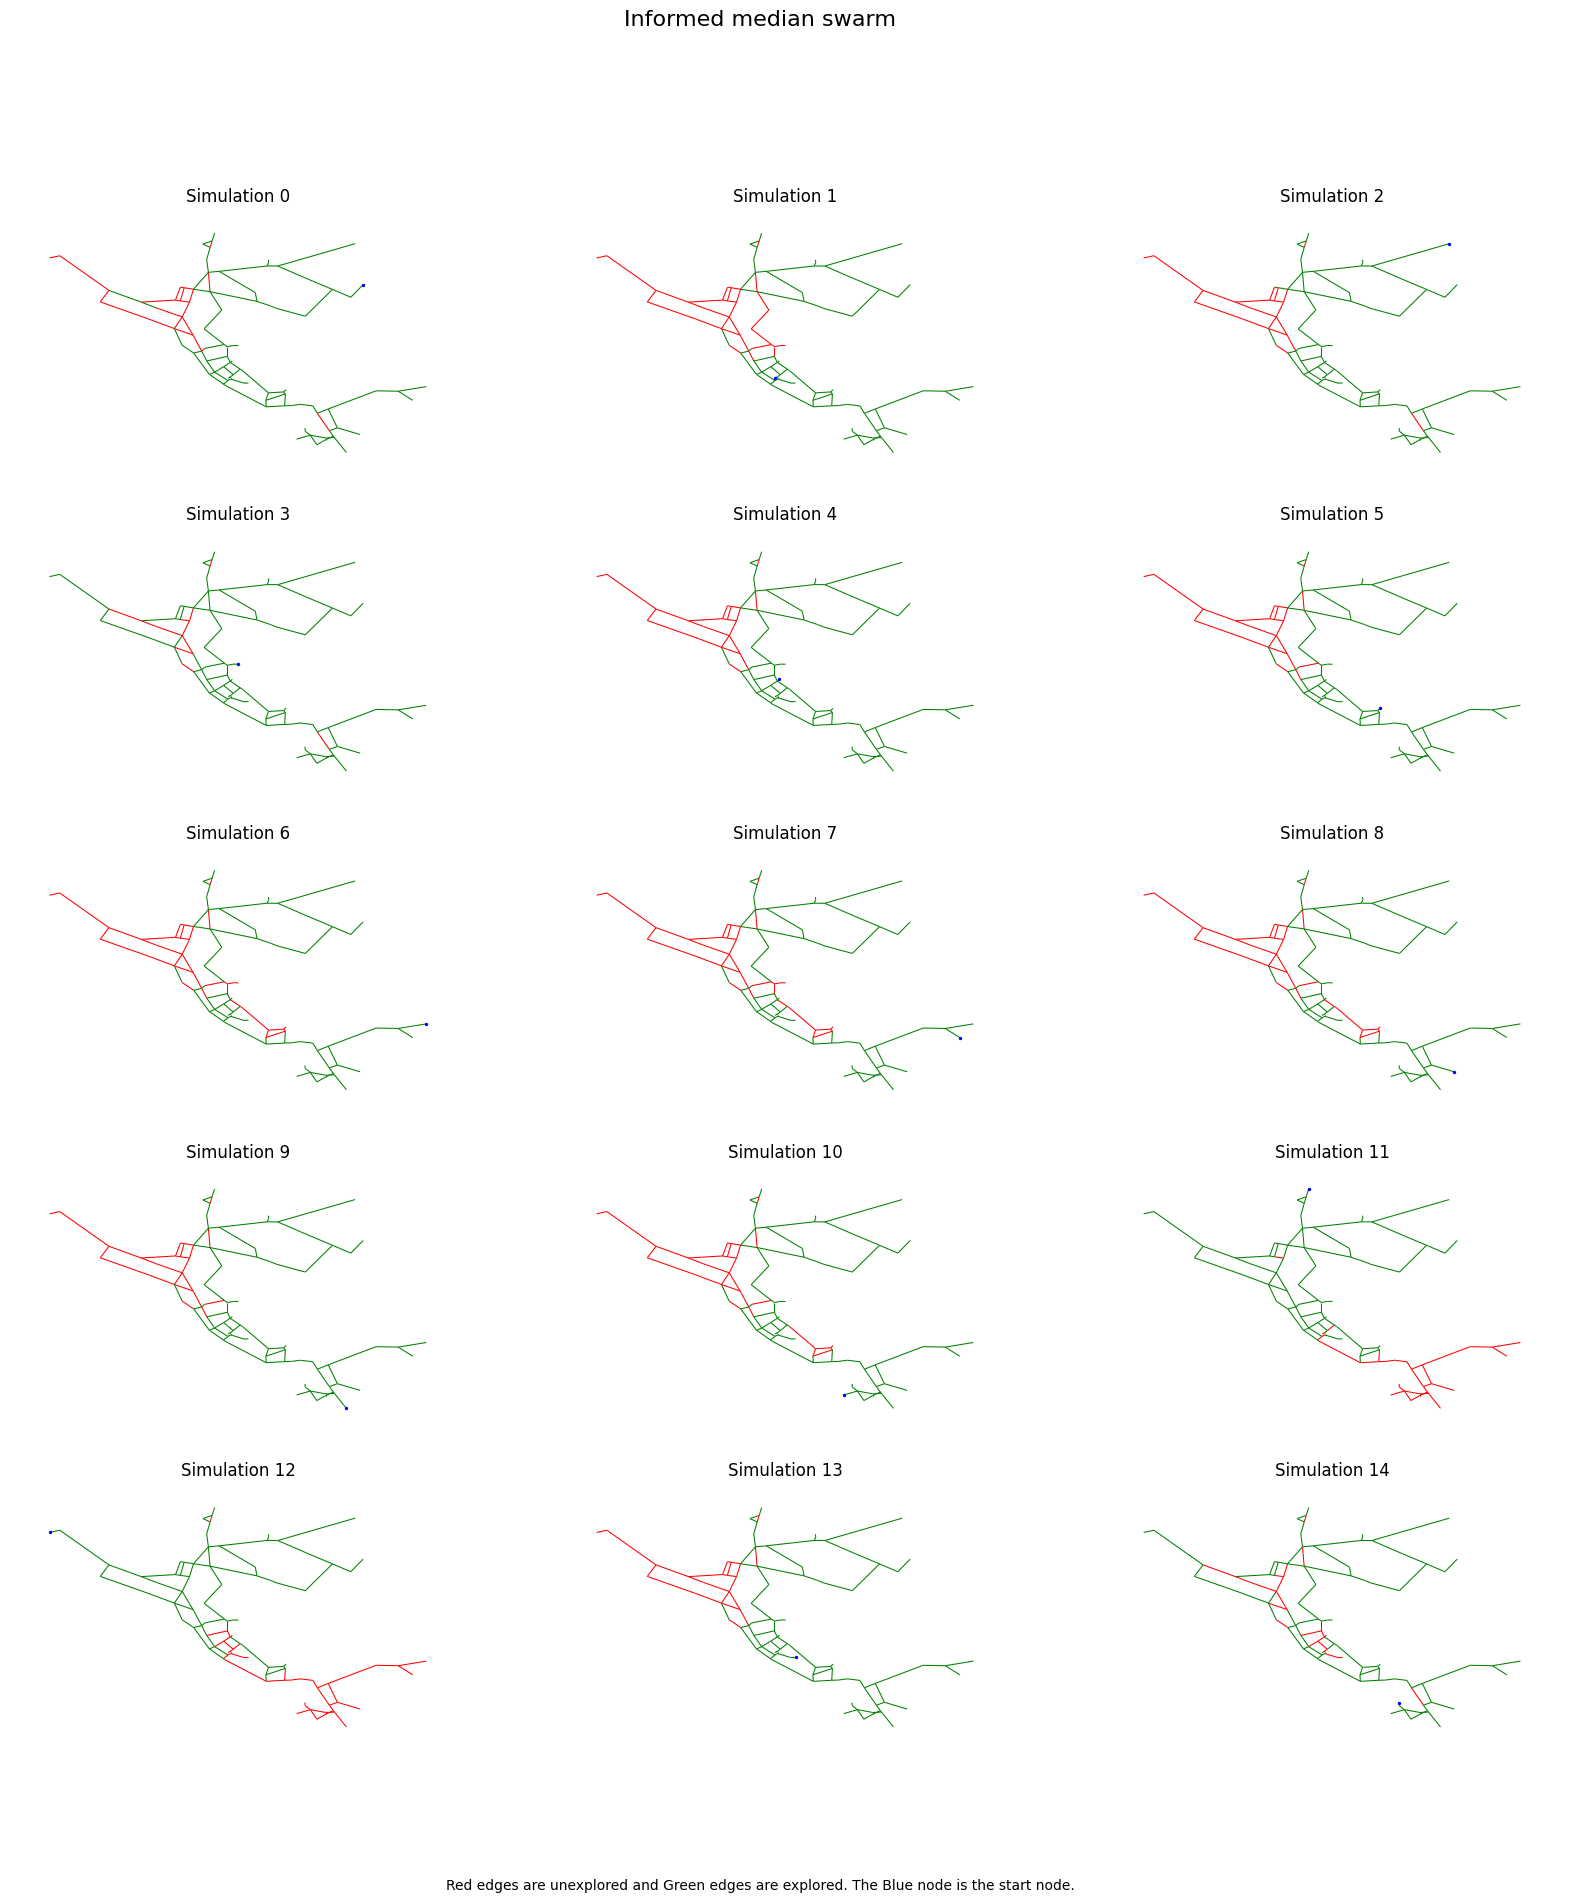

In [32]:
plot_sim_batch(informed_median_swarm_env1, env1, 'Informed median swarm')

## Statistical tests on the mean number of links explored in 100 turns for different swarm control strategies

In [58]:
def num_links_explored(simulations):
    num_links_explored = []
    for sim in simulations:
        start_node, path = sim
        results = pd.read_csv(f'{path}/results.csv')
        num_links_explored.append(results['abs_links_explored'].iloc[-1])
        
    return num_links_explored

def batch_num_links_explored(swarm_types, sim_batch):
    num_links = {}
    for swarm_type, sim in zip(swarm_types, sim_batch):
        num_links.update({swarm_type: num_links_explored(sim)})
        
    return num_links

def batch_mean_links_explored(swarm_types, sim_batch):
    means = {}
    for swarm_type, sim in zip(swarm_types, sim_batch):
        means[swarm_type] = np.mean(num_links_explored(sim))
        
    return means

### Environment 1

In [60]:
sims = [no_swarm_env1, naive_swarm_env1, informed_mean_swarm_env1, informed_median_swarm_env1]
env1_means = batch_mean_links_explored(swarm_types, sims)
env1_nums = batch_num_links_explored(swarm_types, sims)

In [62]:
no_swarm = env1_nums.get('no-swarm')
naive = env1_nums.get('naive')
informed_mean = env1_nums.get('informed-mean')
informed_median = env1_nums.get('informed-median')

#### ANOVA Test

In [63]:
# Test for normality using the Shapiro-Wilk test
_, p_no_swarm = stats.shapiro(no_swarm)
_, p_naive = stats.shapiro(naive)
_, p_informed_mean = stats.shapiro(informed_mean)
_, p_informed_median = stats.shapiro(informed_median)

In [64]:
# Test for equality of variances using the Levene test
_, p_levene = stats.levene(no_swarm, naive, informed_mean, informed_median)

In [74]:
# Test if the ANOVA assumptions are met
if p_no_swarm > 0.05 and p_naive > 0.05 and p_informed_mean > 0.05 and p_informed_median > 0.05 and p_levene > 0.05:
    print('The ANOVA assumptions are met.')
else:
    print('The ANOVA assumptions are not met.')
    print(f'p_no_swarm: {p_no_swarm}')
    print(f'p_naive: {p_naive}')
    print(f'p_informed_mean: {p_informed_mean}')
    print(f'p_informed_median: {p_informed_median}')
    print(f'p_levene: {p_levene}')
    

The ANOVA assumptions are not met.
p_no_swarm: 0.011339740827679634
p_naive: 0.01039065420627594
p_informed_mean: 0.36019089818000793
p_informed_median: 0.36019089818000793
p_levene: 0.0007368868746405089


#### Kruskal-Wallis Test

In [72]:
# Perform the Kruskal-Wallis test
stat, p_val = stats.kruskal(no_swarm, naive, informed_mean, informed_median)
print(f'The Kruskal-Wallis test statistic is {stat}')
print(f'The Kruskal-Wallis p-value is {p_val:.10f}')

The Kruskal-Wallis test statistic is 27.434225548174954
The Kruskal-Wallis p-value is 0.0000047738


In [73]:
if p_val > 0.05:
    print('The Kruskal-Wallis test indicates that there is no significant difference between the number of links explored by the different swarm types.')
else:
    print('The Kruskal-Wallis test indicates that there is a significant difference between the number of links explored by the different swarm types.')

The Kruskal-Wallis test indicates that there is a significant difference between the number of links explored by the different swarm types.


##### Post-hoc Dunn's Test

In [84]:
# Perform the post-hoc Dunn's test using the 
data = np.array([no_swarm, naive, informed_mean, informed_median])
dunn = sp.posthoc_dunn(data, p_adjust='holm', val_col='number of links explored', group_col='swarm type')


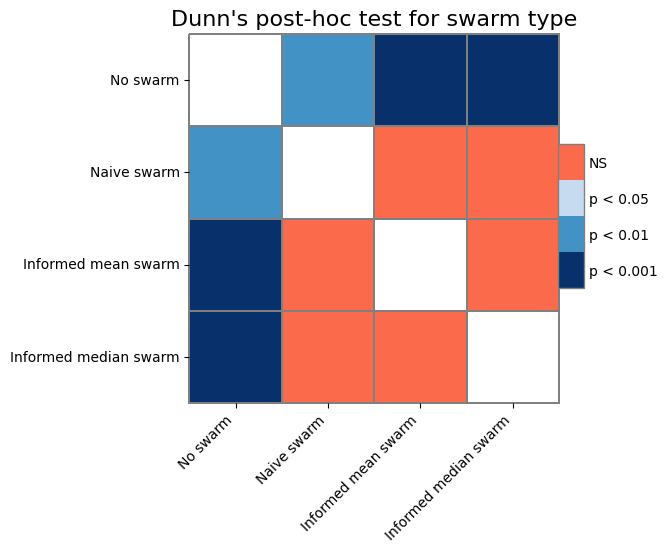

In [108]:
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
plot = sp.sign_plot(dunn, **heatmap_args)
ax, _ = plot # type: ignore
ax.set_title('Dunn\'s post-hoc test for swarm type', fontsize=16)
# replace the swarm type labels with the swarm type names
labels = ['No swarm', 'Naive swarm', 'Informed mean swarm', 'Informed median swarm']
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)
plt.show()
